In [3]:
# Function to rename and move folders
def rename_and_merge(source_path, destination_path):
    for plant in os.listdir(source_path):  # Loop through plants (e.g., Apple, Bell Pepper)
        plant_path = os.path.join(source_path, plant)
        if os.path.isdir(plant_path):
            for split in ['Train', 'Val', 'Test']:
                split_path = os.path.join(plant_path, split)
                if os.path.isdir(split_path):
                    for condition in os.listdir(split_path):  # E.g., Healthy, Apple Scab
                        condition_path = os.path.join(split_path, condition)
                        if os.path.isdir(condition_path) and not condition.startswith('.'):  # Ignore hidden dirs
                            # Create a new folder name with plant name
                            if condition.lower() == "healthy":
                                new_folder_name = f"{plant}_Healthy"
                            else:
                                new_folder_name = f"{plant}_{condition.replace(' ', '_')}"
                            
                            # Create destination folder
                            target_folder = os.path.join(destination_path, split, new_folder_name)
                            os.makedirs(target_folder, exist_ok=True)
                            
                            # Move all images to the renamed folder
                            for img in os.listdir(condition_path):
                                src = os.path.join(condition_path, img)
                                dest = os.path.join(target_folder, img)
                                if os.path.isfile(src):  # Ensure src is a file
                                    shutil.copy(src, dest)

# Rename and merge
rename_and_merge(source_path, destination_path)
print("Dataset reorganized and renamed successfully!")

Dataset reorganized and renamed successfully!


In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Paths for the renamed dataset
TRAIN_PATH = '/kaggle/working/renamed_dataset/Train'
VAL_PATH = '/kaggle/working/renamed_dataset/Val'
TEST_PATH = '/kaggle/working/renamed_dataset/Test'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = ImageFolder(VAL_PATH, transform=transform)
test_dataset = ImageFolder(TEST_PATH, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names
print(f"Classes: {train_dataset.classes}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Classes: ['Apple_Apple_Scab', 'Apple_Black_Rot', 'Apple_Cedar_Apple_Rust', 'Apple_Healthy', 'Bell Pepper_Bacterial_Spot', 'Bell Pepper_Healthy', 'Cherry_Healthy', 'Cherry_Powdery_Mildew', 'Corn (Maize)_Cercospora_Leaf_Spot', 'Corn (Maize)_Common_Rust_', 'Corn (Maize)_Healthy', 'Corn (Maize)_Northern_Leaf_Blight', 'Grape_Black_Rot', 'Grape_Esca_(Black_Measles)', 'Grape_Healthy', 'Grape_Leaf_Blight', 'Peach_Bacterial_Spot', 'Peach_Healthy', 'Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight', 'Strawberry_Healthy', 'Strawberry_Leaf_Scorch', 'Tomato_Bacterial_Spot', 'Tomato_Early_Blight', 'Tomato_Healthy', 'Tomato_Late_Blight', 'Tomato_Septoria_Leaf_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']
Number of classes: 29
Training samples: 53690
Validation samples: 12067
Test samples: 1354


In [5]:
import timm
import torch
from torch import nn

# Load the PiT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('pit_s_224', pretrained=True, num_classes=len(train_dataset.classes))
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

print("Model loaded successfully!")

model.safetensors:   0%|          | 0.00/93.9M [00:00<?, ?B/s]

Model loaded successfully!


In [7]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}: Train Loss = {running_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Train the model
train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1: Train Loss = 171.5080, Train Accuracy = 96.57%
Validation Loss: 39.1473, Validation Accuracy: 96.54%
Epoch 2: Train Loss = 154.6822, Train Accuracy = 96.98%
Validation Loss: 79.2957, Validation Accuracy: 93.26%
Epoch 3: Train Loss = 129.2795, Train Accuracy = 97.41%
Validation Loss: 32.2419, Validation Accuracy: 97.06%
Epoch 4: Train Loss = 121.4094, Train Accuracy = 97.52%
Validation Loss: 25.8061, Validation Accuracy: 97.80%
Epoch 5: Train Loss = 112.3741, Train Accuracy = 97.71%
Validation Loss: 34.2649, Validation Accuracy: 97.11%
Epoch 6: Train Loss = 109.8763, Train Accuracy = 97.76%
Validation Loss: 37.2013, Validation Accuracy: 96.64%
Epoch 7: Train Loss = 93.6765, Train Accuracy = 98.12%
Validation Loss: 21.4213, Validation Accuracy: 98.06%
Epoch 8: Train Loss = 92.4043, Train Accuracy = 98.11%
Validation Loss: 28.5459, Validation Accuracy: 97.42%
Epoch 9: Train Loss = 87.2006, Train Accuracy = 98.22%
Validation Loss: 26.2749, Validation Accuracy: 97.75%
Epoch 10: Tra

In [8]:
torch.save(model.state_dict(), '/kaggle/working/pit_model_final.pth')
print("Model saved at /kaggle/working/pit_model_final.pth")

Model saved at /kaggle/working/pit_model_final.pth


Classification Report:
                                   precision    recall  f1-score   support

                 Apple_Apple_Scab       1.00      0.94      0.97        51
                  Apple_Black_Rot       1.00      0.98      0.99        50
           Apple_Cedar_Apple_Rust       1.00      0.98      0.99        44
                    Apple_Healthy       0.96      1.00      0.98        51
       Bell Pepper_Bacterial_Spot       1.00      1.00      1.00        48
              Bell Pepper_Healthy       0.98      0.96      0.97        50
                   Cherry_Healthy       0.98      1.00      0.99        46
            Cherry_Powdery_Mildew       1.00      1.00      1.00        43
Corn (Maize)_Cercospora_Leaf_Spot       0.95      0.95      0.95        41
        Corn (Maize)_Common_Rust_       1.00      0.98      0.99        48
             Corn (Maize)_Healthy       0.98      1.00      0.99        47
Corn (Maize)_Northern_Leaf_Blight       0.96      0.96      0.96        48
 

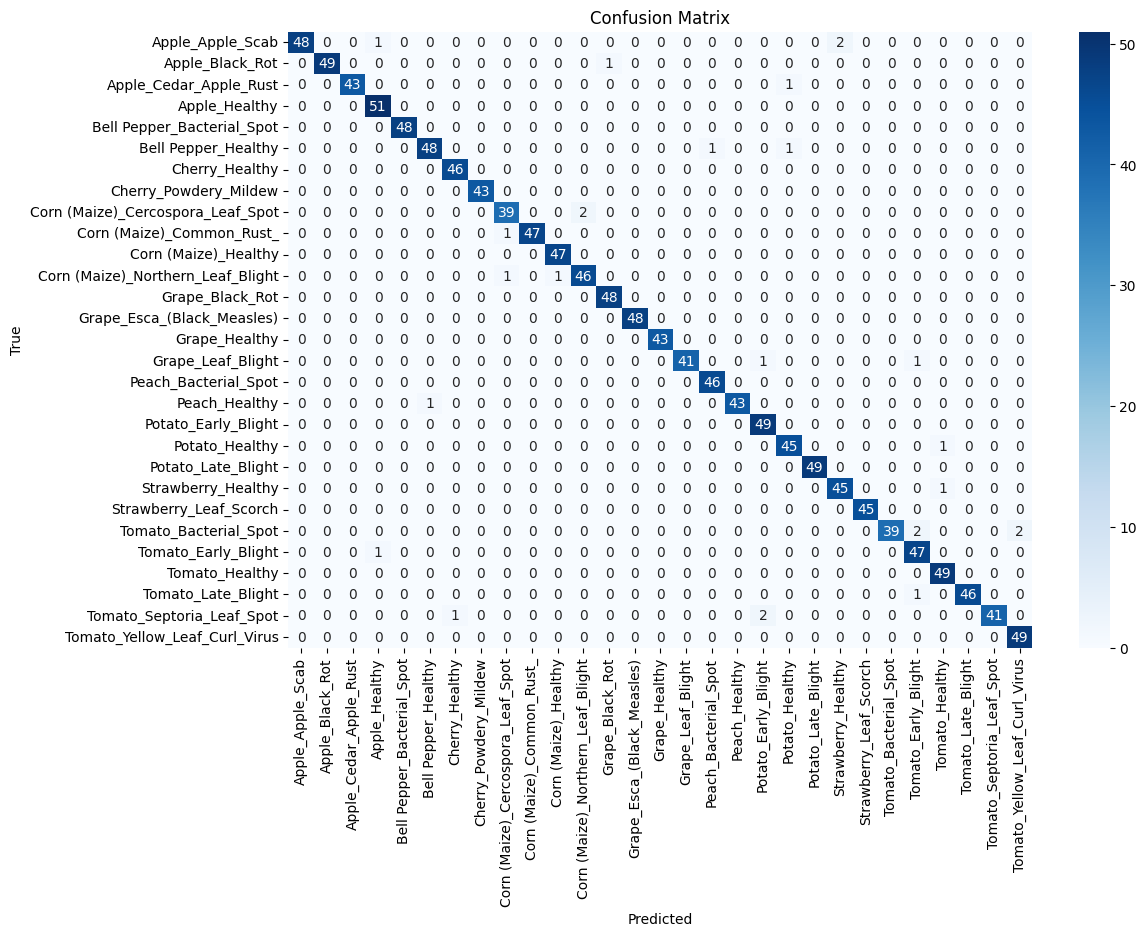

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
evaluate_model(model, test_loader)

In [13]:
!pip install ptflops

In [14]:
from ptflops import get_model_complexity_info

# Input size for the PiT model (C=3, H=W=224 for ImageNet-sized images)
input_size = (3, 224, 224)

# Calculate FLOPs and parameters
with torch.no_grad():
    macs, params = get_model_complexity_info(model, input_size, as_strings=True, verbose=True)
    print(f"FLOPs: {macs}")
    print(f"Number of parameters: {params}")

PoolingVisionTransformer(
  22.8 M, 99.541% Params, 2.1 GMac, 99.874% MACs, 
  (patch_embed): ConvEmbedding(
    110.74 k, 0.484% Params, 80.73 MMac, 3.831% MACs, 
    (conv): Conv2d(110.74 k, 0.484% Params, 80.73 MMac, 3.831% MACs, 3, 144, kernel_size=(16, 16), stride=(8, 8))
  )
  (pos_drop): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.0, inplace=False)
  (transformers): SequentialTuple(
    22.67 M, 98.979% Params, 2.02 GMac, 96.042% MACs, 
    (0): Transformer(
      501.41 k, 2.189% Params, 554.87 MMac, 26.333% MACs, 
      (norm): Identity(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
      (blocks): Sequential(
        501.41 k, 2.189% Params, 554.87 MMac, 26.333% MACs, 
        (0): Block(
          250.7 k, 1.095% Params, 277.43 MMac, 13.166% MACs, 
          (norm1): LayerNorm(288, 0.001% Params, 105.12 KMac, 0.005% MACs, (144,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            83.52 k, 0.365% Params, 155.18 MMac, 7.365% MACs, 
            (qkv

In [15]:
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Use the trained PiT model
input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1, image size 224x224

# Compute FLOPs and parameter count
flops = FlopCountAnalysis(model, input_tensor)
print(f"Total FLOPs for PiT: {flops.total() / 1e9:.2f} GFLOPs")  # Convert to GFLOPs

# Parameter count
print("Model Parameters:")
print(parameter_count_table(model))

Total FLOPs for PiT: 2.42 GFLOPs
Model Parameters:
| name                       | #elements or shape   |
|:---------------------------|:---------------------|
| model                      | 22.9M                |
|  pos_embed                 |  (1, 144, 27, 27)    |
|  cls_token                 |  (1, 1, 144)         |
|  patch_embed               |  0.1M                |
|   patch_embed.conv         |   0.1M               |
|    patch_embed.conv.weight |    (144, 3, 16, 16)  |
|    patch_embed.conv.bias   |    (144,)            |
|  transformers              |  22.7M               |
|   transformers.0           |   0.5M               |
|    transformers.0.blocks   |    0.5M              |
|   transformers.1           |   6.0M               |
|    transformers.1.pool     |    44.6K             |
|    transformers.1.blocks   |    6.0M              |
|   transformers.2           |   16.1M              |
|    transformers.2.pool     |    0.2M              |
|    transformers.2.blocks   | 

In [16]:
# Use CUDA events for precise GPU timing
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

# Input batch size of 32 for processing speed analysis
batch_size = 32
input_tensor = torch.randn(batch_size, 3, 224, 224).to(device)  # Move input to GPU

# Measure processing time
model.eval()
start_event.record()
with torch.no_grad():
    for _ in range(10):  # Run multiple iterations for reliable results
        output = model(input_tensor)
end_event.record()

torch.cuda.synchronize()  # Wait for all operations to finish
elapsed_time = start_event.elapsed_time(end_event) / 10  # Average time in milliseconds
print(f"Average processing time per batch on GPU: {elapsed_time:.2f} ms")
time_per_image = elapsed_time / batch_size
print(f"Average processing time per image on GPU: {time_per_image:.2f} ms")


Average processing time per batch on GPU: 40.92 ms
Average processing time per image on GPU: 1.28 ms


In [21]:
import time
# Move model and input to CPU
model = model.to('cpu')
input_tensor = input_tensor.to('cpu')

# Timing using CPU
start_time = time.time()
with torch.no_grad():
    for _ in range(10):
        output = model(input_tensor)
end_time = time.time()

cpu_time_per_batch = (end_time - start_time) / 10
print(f"Average processing time per batch on CPU: {cpu_time_per_batch:.2f} seconds")
cpu_time_per_image = cpu_time_per_batch / batch_size
print(f"Average processing time per image on CPU: {cpu_time_per_image:.2f} ms")

Average processing time per batch on CPU: 1.33 seconds
Average processing time per image on CPU: 0.04 ms


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model = model.to(device)

# Ensure input tensor is on the same device
input_tensor = input_tensor.to(device)


# Function to evaluate and collect predictions
def collect_predictions(model, test_loader):
    model.eval()
    all_preds, all_labels, all_images = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())
    return np.array(all_images), np.array(all_labels), np.array(all_preds)

# Collect predictions
images, labels, preds = collect_predictions(model, test_loader)

# Identify correct and incorrect predictions
correct_indices = np.where(labels == preds)[0]
incorrect_indices = np.where(labels != preds)[0]

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display examples
def display_examples(images, labels, preds, indices, class_names, title, num_examples=5):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:num_examples]):
        plt.subplot(1, num_examples, i + 1)
        img = images[idx].transpose(1, 2, 0)  # Convert to HWC format
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        pred_label = class_names[preds[idx]]
        true_label = class_names[labels[idx]]
        color = "green" if pred_label == true_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


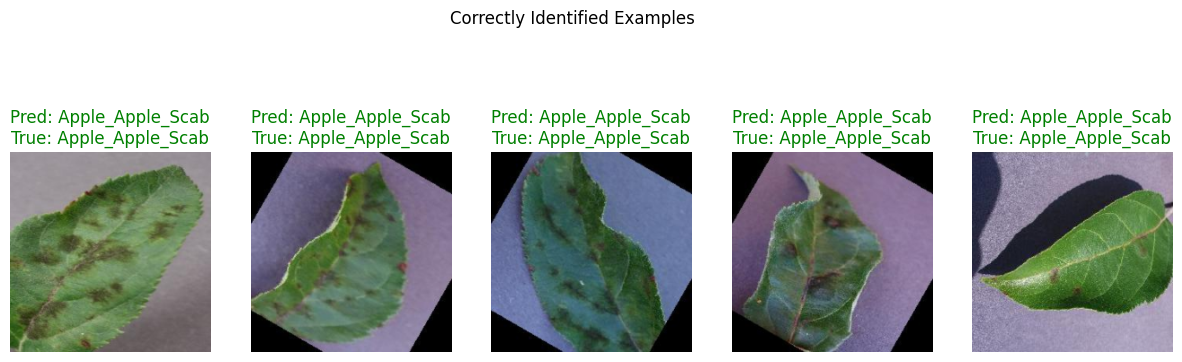

In [25]:
# Display 5 correct predictions
display_examples(images, labels, preds, correct_indices, test_dataset.classes, "Correctly Identified Examples", num_examples=5)


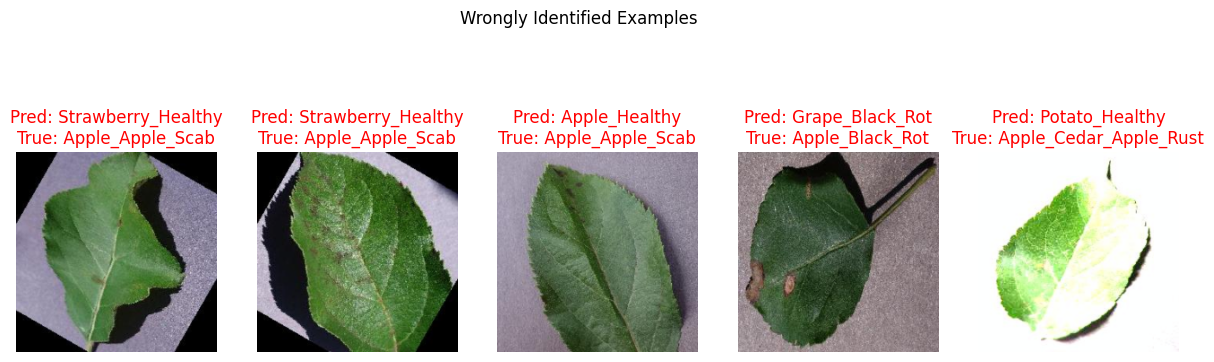

In [26]:
# Display 5 incorrect predictions
display_examples(images, labels, preds, incorrect_indices, test_dataset.classes, "Wrongly Identified Examples", num_examples=5)


In [27]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Function to group indices by label
def group_indices_by_label(labels, indices):
    label_dict = defaultdict(list)
    for idx in indices:
        label_dict[labels[idx]].append(idx)
    return label_dict

# Function to select diverse examples
def select_diverse_examples(grouped_indices, num_examples=5):
    selected_indices = []
    for label, idx_list in grouped_indices.items():
        if len(selected_indices) < num_examples:
            selected_indices.extend(idx_list[:1])  # Take one example per label
    return selected_indices[:num_examples]

# Function to display examples
def display_diverse_examples(images, labels, preds, indices, class_names, title, num_examples=5):
    grouped_indices = group_indices_by_label(labels, indices)  # Group by true label
    selected_indices = select_diverse_examples(grouped_indices, num_examples=num_examples)  # Select diverse examples

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, num_examples, i + 1)
        img = images[idx].transpose(1, 2, 0)  # Convert to HWC format
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        pred_label = class_names[preds[idx]]
        true_label = class_names[labels[idx]]
        color = "green" if pred_label == true_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


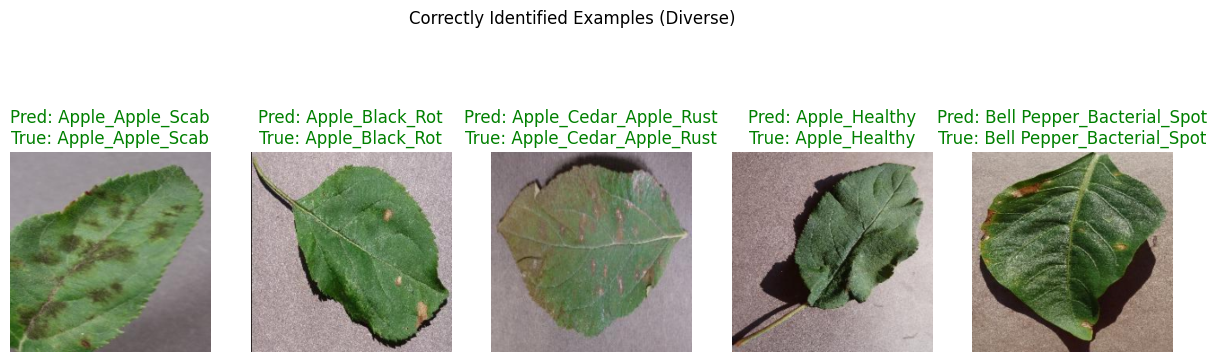

In [28]:
# Display diverse correct predictions
display_diverse_examples(images, labels, preds, correct_indices, test_dataset.classes, "Correctly Identified Examples (Diverse)", num_examples=5)


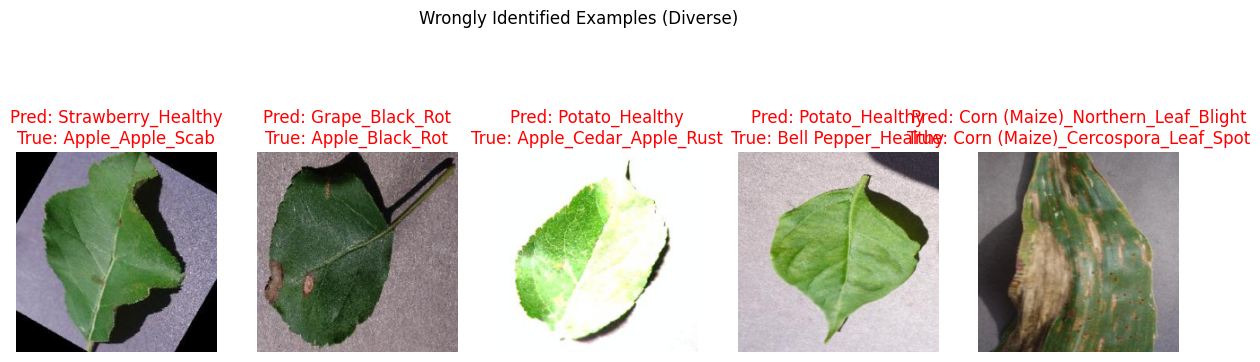

In [29]:
# Display diverse incorrect predictions
display_diverse_examples(images, labels, preds, incorrect_indices, test_dataset.classes, "Wrongly Identified Examples (Diverse)", num_examples=5)
